In [7]:
import sys
import os
import json
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm, ListedColormap
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage

In [8]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

## Stem plots of feature importance (normalized between 0 and 1) for each of the models
## Rank the top 10 or 20 features by the best performing method (OLS) 
### Within each feature, separate into 4 stem lines, one for each model

### Models to use:
    1. OLS
    2. LASSO 
    3. PLS
    4. RF
    5. Individual linear regression 
        - A scaled feature importance can be derived from the -log10(q-value) for each Fed & Fasted fit 
    - Skip SVM and Ridge because within our data they are identical to OLS

In [42]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)
r = r.loc[(r['y'] == 'ogtt') & (r['model'].isin(['ols', 'lasso', 'pls', 'rf']))].drop('y', axis=1)
cols = ['model', 'x']
cols.extend(data.index)
r = r[cols]
r['i'] = r['model'] + '_' + r['x']
new_cols = r['i']
r = r.drop(['model', 'x'], axis=1)
r = r.set_index('i').T.abs()
# r = r.loc[data['ID'] != 'unknown']  # only use IDs
# r = r.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')]
r.loc[:, :] = MinMaxScaler().fit_transform(r)  # perform 0 to 1 scaling of absolute value of coefficients
r = r.join(data)
r = r.sort_values('ols_Fed', ascending=False)  # .iloc[:20]
r['y_point'] = range(len(r))  # range(len(r), 0, -1)
r['is_id'] = r['ID'] != 'Unidentified'
r['avg_Fed'] = r.filter(regex='_Fed').mean(axis=1)
r['avg_Fasted'] = r.filter(regex='_Fasted').mean(axis=1)
r

,ols_Fed,ols_Fasted,lasso_Fed,lasso_Fasted,pls_Fed,pls_Fasted,rf_Fed,rf_Fasted,unique_id,ID,...,pval_fed,coef_fed,intercept_fed,pval_fasted,coef_fasted,intercept_fasted,y_point,is_id,avg_Fed,avg_Fasted
m_168,1.000000,0.311024,0.197380,0.000097,0.717538,0.448586,0.009193,0.017583,Unidentified_9.94_174.001,Unidentified,...,0.002253,-0.000008,25.326000,0.010922,-0.000007,25.215769,0,False,0.481028,0.194322
l_851,0.976530,0.839134,0.849482,0.278218,1.000000,0.683038,0.113422,0.035210,Unidentified_18.11_1896.745,Unidentified,...,0.000002,0.000033,20.651323,0.013042,0.000019,21.492409,1,False,0.734859,0.458900
l_847,0.871360,0.299581,0.206165,0.000000,0.742111,0.447920,0.015003,0.003173,Unidentified_18.057_1948.7765,Unidentified,...,0.000276,-0.000016,22.060498,0.047039,-0.000008,21.838268,2,False,0.458660,0.187668
m_356,0.850666,0.636858,0.132863,0.024025,0.555763,0.482789,0.002041,0.009808,Unidentified_13.284_182.031,Unidentified,...,0.042221,-0.000033,18.744247,0.110225,-0.000026,18.270622,3,False,0.385333,0.288370
m_135,0.842116,0.326765,0.183395,0.000138,0.655561,0.056579,0.003617,0.001622,3-Indoxyl sulphate_8.177_212.0014,3-Indoxyl sulphate,...,0.012776,-0.000023,22.690663,0.701786,-0.000003,21.571179,4,True,0.421172,0.096276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_870,0.001184,0.158577,0.000000,0.000000,0.138630,0.170359,0.007024,0.005577,Unidentified_18.542_941.7338,Unidentified,...,0.000567,0.000034,18.210698,0.931488,-0.000001,18.616715,1407,False,0.036710,0.083628
l_555,0.000723,0.131264,0.000000,0.000000,0.057415,0.503897,0.012382,0.002694,Cer[NS] d18:1_24:1_12.627_646.615,Cer[NS] d18:1_24:1,...,0.033056,0.000012,20.034462,0.014436,-0.000014,21.394989,1408,True,0.017630,0.159464
l_380,0.000702,0.327735,0.000000,0.000000,0.411610,0.011617,0.009899,0.002088,Plasmanyl-PC O-38:5_9.45_794.6071,Plasmanyl-PC O-38:5,...,0.000703,0.000018,22.014240,0.731218,-0.000003,22.206365,1409,True,0.105553,0.085360
l_903,0.000023,0.087103,0.000000,0.000000,0.056966,0.422494,0.007989,0.000372,Unidentified_19.573_593.5873,Unidentified,...,0.002058,0.000042,15.668195,0.154301,-0.000014,19.791931,1410,False,0.016244,0.127492


,ID,y_pos,variable,value,y_offset
0,FA 18:0,-0.375,ols,0.828009,-0.375
1,SM d37:1,0.625,ols,0.759212,-0.375
2,CE 18:1,1.625,ols,0.730727,-0.375
3,PC 38:7,2.625,ols,0.713478,-0.375
4,Plasmanyl-PC O-20:0_20:4,3.625,ols,0.712840,-0.375


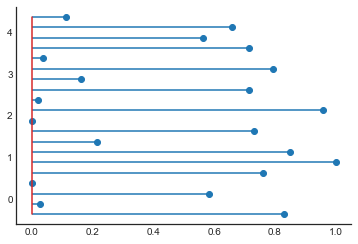

In [40]:
# fed_cols = r.filter(regex='_Fed').columns
fed_cols = ['ols_Fed', 'lasso_Fed', 'pls_Fed', 'rf_Fed', 'ID']
# fasted_cols = r.filter(regex='_Fasted').columns
df = (r
      .sort_values('ols_Fed', ascending=False)
      .loc[(r['ID'] != 'Unidentified') & (r['Type'] == 'lipid'), fed_cols]      
      .iloc[:5]
      )
df['y_pos'] = range(len(df))

df = df.melt(id_vars=['ID', 'y_pos'])
df['variable'] = df['variable'].str[:-4]
df['y_offset'] = df['variable'].map({'ols': -0.375, 'lasso': -0.125, 'pls': 0.125, 'rf': 0.375})
df['y_pos'] = df['y_pos'] + df['y_offset']
display(df.head())


plt.stem(
    df['y_pos'], df['value'],
    orientation='horizontal',
)
sns.despine()

In [147]:
def plot_importance(Type, sampling, is_id=True, num_features=20, 
                    model_ranking='ols', models=['ols', 'lasso', 'pls', 'rf'],
                    stem=False):
    """
    Type = 'lipid', 'metabolite' or '' empty string to get all 
    sampling = 'Fed' or 'Fasted'
    is_id = True for only IDs, False for only un-IDs, 
    """
    df = r.copy()
    df = (df.loc[(df['is_id'] == is_id) & (df['Type'].str.contains(Type))] 
          .sort_values(f'{model_ranking}_{sampling}', ascending=False) 
          .iloc[:num_features] 
          .melt(id_vars=['ID'], value_vars=[model+'_'+sampling for model in models]) 
         )
    fig, ax = plt.subplots(figsize=(4, 1.6 + 0.4*num_features), dpi=80)
    bp = sns.barplot(
        data=df, x='value', y='ID', orient='horizontal', hue='variable',
        palette=sns.color_palette('cubehelix', len(models)),  # 'Set2' 'cubehelix', 'hls', 'husl', 'Dark2', 'brg'
        edgecolor='0.2', 
        alpha=1, saturation=0.9, ci=None, dodge=True, ax=ax)
    for patch in bp.patches:  # Set bar width, because the 'width' parameter in sns.barplot is broken 
        if stem:
            patch.set_height(0.08)
            patch.set_linewidth(0)
            bb = patch.get_bbox()
            ax.scatter([bb.x1], [bb.y1-0.05], color=patch.get_facecolor(), s=55)
        if not stem:
            patch.set_height(0.16)
        
    plt.yticks(fontsize=15)
    plt.ylabel('Identification', fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('Scaled feature importance', fontsize=15)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=[x.upper() for x in models], 
               title='Model', title_fontsize=16, 
               loc=(0.95, 0.3), fontsize=14, markerscale=2)
    # plt.axvline(1, c='gray', alpha=0.7)
    plt.grid(axis='x', visible=None)
#     for y_pos in np.arange(ax.get_ylim()[1], ax.get_ylim()[0], len(df)):
#         ax.axhspan(y_pos)
    sns.despine()
    return bp

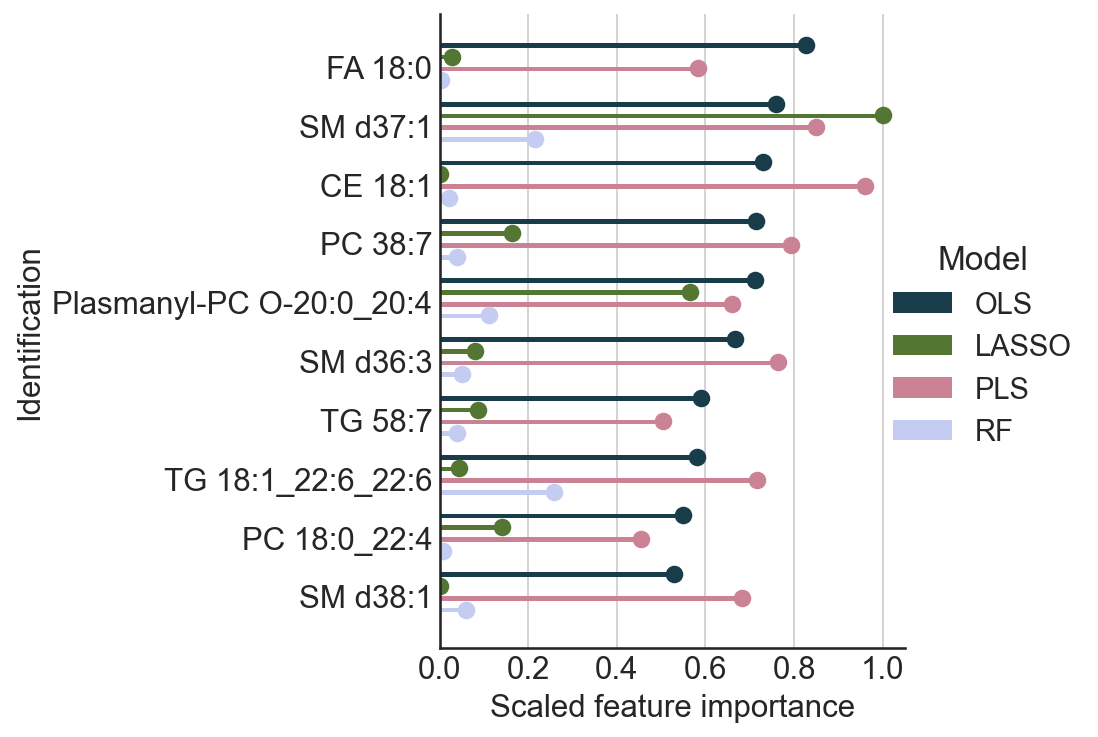

In [148]:
bp = plot_importance(Type='lipid', is_id=True, sampling='Fed', num_features=10, model_ranking='ols', stem=True)
fig = plt.gcf()
fig.set_facecolor('white')
fig.set_dpi(150)

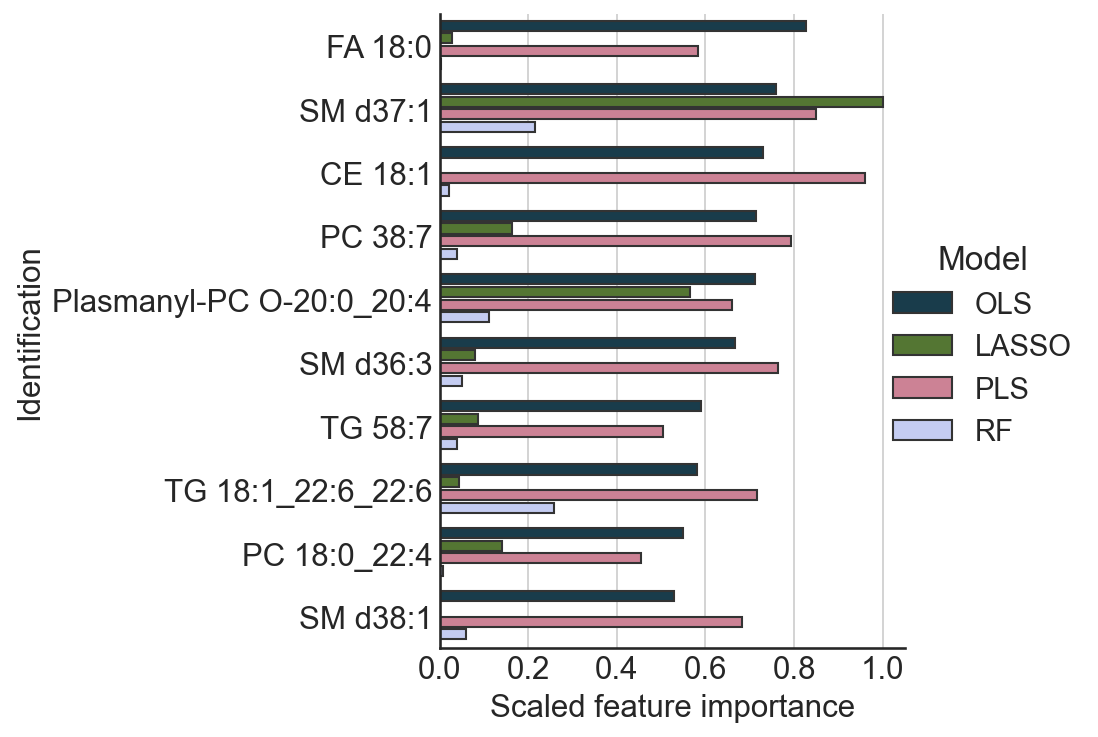

In [149]:
bp = plot_importance(Type='lipid', is_id=True, sampling='Fed', num_features=10, model_ranking='ols', stem=False)
fig = plt.gcf()
fig.set_facecolor('white')
fig.set_dpi(150)

Text(0.5, 1.0, 'Top 10 predictive Lipids\nin Fed models')

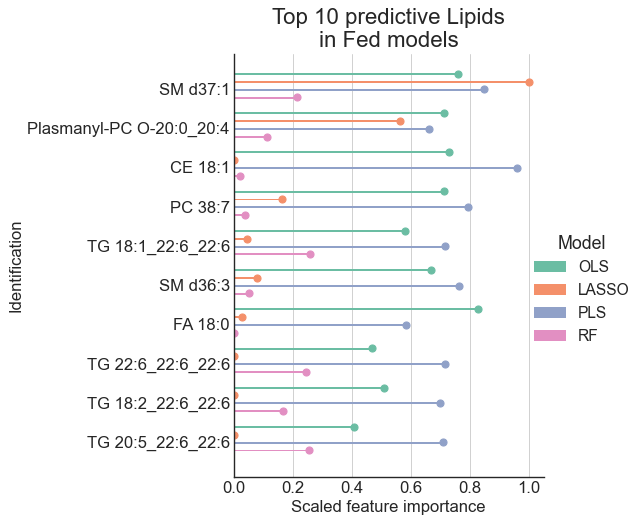

In [85]:
plot_importance(Type='lipid', is_id=True, sampling='Fed', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive Lipids\nin Fed models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fed.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fed.pdf', bbox_inches='tight', dpi=100, facecolor='white')

# plt.figure()
# plot_importance(Type='lipid', is_id=True, sampling='Fasted', num_features=10, model_ranking='avg')
# plt.title('Top 10 predictive Lipids\nin Fasted models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fasted.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fasted.pdf', bbox_inches='tight', dpi=100, facecolor='white')


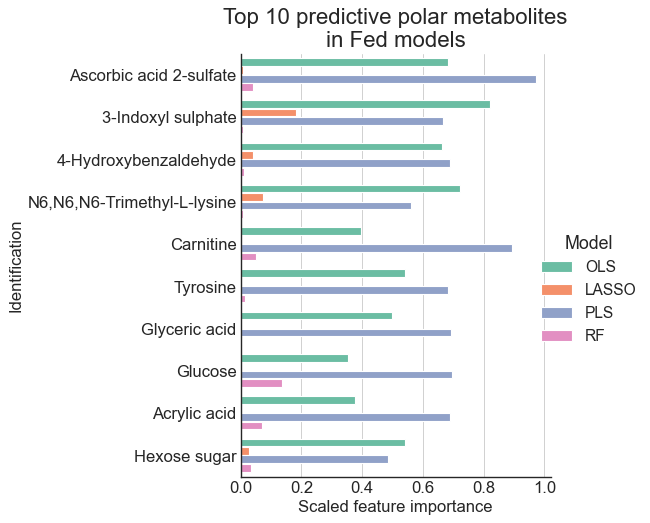

<Figure size 432x288 with 0 Axes>

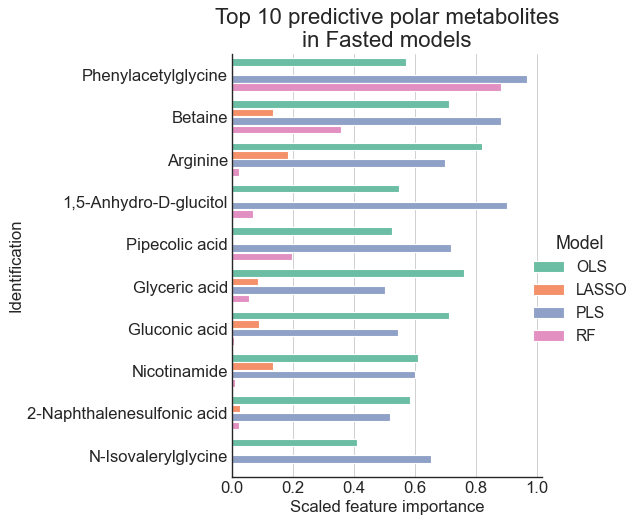

In [207]:
plot_importance(Type='metabolite', is_id=True, sampling='Fed', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive polar metabolites\nin Fed models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fed.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fed.pdf', bbox_inches='tight', dpi=100, facecolor='white')

plt.figure()
plot_importance(Type='metabolite', is_id=True, sampling='Fasted', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive polar metabolites\nin Fasted models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fasted.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fasted.pdf', bbox_inches='tight', dpi=100, facecolor='white')


In [4]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv')

ranks = r.loc[(r['y'] == 'ogtt') \
              & (~r['model'].isin(['lasso'])),  # Dropping LASSO justifiable because only 251/1371 features 
                                                #    are nonzero, which messes up the rankings 
              data.index].abs().rank(axis=1, ascending=False)
# display(ranks)
avg_rank = ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fed')].mean().sort_values().to_frame('Fed')

avg_rank = avg_rank.join(ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fasted')].mean().to_frame('Fasted'))
avg_rank = avg_rank.join(data[['qval_fed', 'qval_fasted', 'ID']])
avg_rank.loc[:, ['qval_fed', 'qval_fasted']] = avg_rank.loc[:, ['qval_fed', 'qval_fasted']].rank(ascending=True)
ids_ranks = avg_rank.loc[avg_rank['ID'] != 'unknown']
ids_ranks.rename({'Fed': 'Avg. rank fed models', 'Fasted': 'Avg. rank fasted models',
                  'qval_fed': 'Fed linear model rank', 'qval_fasted': 'Fasted linear model rank'}, axis=1, inplace=True)
ids_ranks.iloc[:50]

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Avg. rank fed models,Avg. rank fasted models,Fed linear model rank,Fasted linear model rank,ID
i,,,,,
l_393,18.0,794.8,24.5,1170.5,SM d37:1
l_604,48.2,236.8,12.5,139.0,TG 18:1_22:6_22:6
l_159,51.8,698.0,186.5,852.5,SM d36:3
l_461,51.8,24.4,128.0,35.0,Plasmanyl-PC O-20:0_20:4
l_150,55.6,591.6,449.5,835.0,PC 38:7
l_567,63.2,273.0,9.0,32.0,TG 18:2_22:6_22:6
m_227,70.8,625.2,672.5,1061.0,Ascorbic acid 2-sulfate
l_538,77.2,148.0,7.0,6.0,TG 22:6_22:6_22:6
l_425,80.2,802.8,313.0,1367.5,SM d38:1


In [10]:
data['qval_fed']

i
m_0      0.005399
m_1      0.000001
m_2      0.563218
m_3      0.531078
m_4      0.562464
           ...   
l_868    0.000212
l_869    0.000701
l_870    0.005132
l_871    0.001391
l_872    0.002125
Name: qval_fed, Length: 1371, dtype: float64